## **Diseño de Cámaras y Pilares (Room & Pillar)**.

El diseño de este método de minado subterráneo requiere un balance delicado entre la **seguridad operativa** (evitar el colapso del techo y pilares) y la **rentabilidad** (maximizar la extracción). En este ejercicio, utilizaremos un enfoque basado en la **Teoría del Área Tributaria** para la carga, y criterios empíricos actualizados para la resistencia del macizo.

***Objetivos de aprendizaje:***
1. Calcular los esfuerzos litostáticos pre-minería.
2. Determinar la resistencia base del macizo rocoso ($K$) de forma dinámica usando el criterio de Hoek-Brown (2002).
3. Evaluar la estabilidad de pilares mediante el Factor de Seguridad ($FS$) y el Factor de Esbeltez ($W_p/H$).
4. Validar el diseño del techo considerando la luz máxima en las **intersecciones**.
5. Simular miles de escenarios mediante un algoritmo de optimización para encontrar el diseño ideal.

> **Nota técnica:** Este modelo analítico asume cuerpos mineralizados horizontales, pilares cuadrados y un medio continuo. Para macizos controlados por fallas estructurales discretas, los resultados deben calibrarse con análisis de cuñas y modelación numérica 3D.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings

warnings.filterwarnings('ignore')
print("✅ Librerías cargadas con éxito.")

✅ Librerías cargadas con éxito.


### **Paso 1: Estado de Esfuerzos y Estabilidad del Techo**

Determinar el esfuerzo vertical ($\sigma_z$) ejercido por el peso de la roca suprayacente. Se calcula mediante la profundidad ($Z$) y el peso específico ($\gamma$). 
$$\sigma_z = \gamma \cdot Z$$

Además, modelaremos el estrato superior inmediato como una para calcular la **Luz Máxima** ($L_{max}$) que el techo puede soportar sin colapsar.

**¡Precaución!** En el método *Room and Pillar*, el punto más crítico para el techo no es el ancho nominal de la cámara ($W_0$), sino la **intersección** donde se cruzan las galerías. Allí, la luz libre real es la diagonal geométrica: 
$$W_{diag} = W_0 \cdot \sqrt{2}$$

In [3]:
# Parámetros:
profundidad = 370.0      # Z en metros
gamma = 0.028            # Peso específico (MN/m3)
sigma_t = 6.0            # Resistencia a la tracción del techo (MPa)
t_techo = 1.0            # Espesor del estrato (m)

# Cálculos:
sigma_z = gamma * profundidad
luz_maxima = np.sqrt((2 * sigma_t * t_techo) / gamma)

print(f"Esfuerzo Vertical (Sigma Z): {sigma_z:.2f} MPa")
print(f"Luz Máxima analítica permitida: {luz_maxima:.2f} metros")

Esfuerzo Vertical (Sigma Z): 10.36 MPa
Luz Máxima analítica permitida: 20.70 metros


### **Paso 2: Caracterización de la Resistencia del Macizo (K)**

Para estimar la resistencia del pilar, la fórmula clásica de Hedley & Grant requiere un parámetro $K$, que representa la resistencia in situ de un cubo de roca de un metro. 

En lugar de usar un valor estático, lo calcularemos dinámicamente utilizando el **Criterio de falla de Hoek-Brown (2002)** para obtener la resistencia global del macizo ($\sigma_{cm}$). El algoritmo calculará el parámetro $a$ y las constantes del macizo basándose en el Índice de Resistencia Geológica (**GSI**) y la resistencia a compresión simple de la roca intacta (**UCS**).

In [4]:
ucs_ci = 180.0           # UCS roca intacta (MPa)
gsi = 87.0               # GSI

# Criterio de Hoek-Brown (2002):
s = np.exp((gsi - 100) / 9)
a_hb = 0.5 + (1/6) * (np.exp(-gsi / 15) - np.exp(-20 / 3))

sigma_cm = ucs_ci * (s ** a_hb)
k = sigma_cm # Constante para Hedley & Grant

print(f"Parámetro 'a' calculado: {a_hb:.4f}")
print(f"Resistencia base del macizo rocoso (K): {k:.2f} MPa")

Parámetro 'a' calculado: 0.5003
Resistencia base del macizo rocoso (K): 87.38 MPa


### **Paso 3: Teoría del Área Tributaria**

Aquí definiremos las ecuaciones que calculan:

1. **Esfuerzo sobre el pilar ($\sigma_p$):** Usando la Teoría del Área Tributaria.
$$\sigma_p = \sigma_z \cdot \frac{(W_p + W_0)^2}{W_p^2}$$

2. **Resistencia del pilar ($S_p$):** Usando la fórmula de Hedley & Grant (1972) para roca dura.
$$S_p = K \cdot \frac{W_p^{0.5}}{H^{0.75}}$$

**Variables Críticas de Diseño a evaluar:**
* **Factor de Seguridad (FS):** La relación $S_p / \sigma_p$. Para este ejercicio, buscaremos un diseño seguro si $FS \ge 1.4$.
* **Factor de Esbeltez ($W_p/H$):** Relación entre el ancho y la altura del pilar. Un pilar muy esbelto falla por pandeo o corte progresivo. Nuestro código exigirá una esbeltez mínima de **0.8**.

**ACTIVIDAD:** Revisa cómo las funciones modulares de Python interactúan para evaluar una lista de propuestas manuales y descartan aquellos diseños que harían colapsar el techo en las intersecciones.

Luz diagonal en intersecciones: 21.21 m
Luz Máxima del techo permitida: 20.70 m
⚠️ ADVERTENCIA: El ancho de cámara elegido provocará colapso en las intersecciones.
------------------------------------------------------------


,Pilar Wp (m),Esfuerzo (MPa),Resistencia (MPa),Factor Seguridad,Recuperación (%),Estado
0,2.0,748.51,21.98,0.03,98.62,❌ RIESGO (Colapso)
1,4.0,233.75,31.08,0.13,95.57,❌ RIESGO (Colapso)
2,6.0,126.91,38.06,0.30,91.84,❌ RIESGO (Colapso)
3,8.0,85.63,43.95,0.51,87.90,❌ RIESGO (Colapso)
4,10.0,64.75,49.14,0.76,84.00,❌ RIESGO (Colapso)
5,12.0,52.45,53.83,1.03,80.25,❌ RIESGO (Colapso)
6,14.0,44.45,58.14,1.31,76.69,❌ RIESGO (Colapso)
7,16.0,38.89,62.16,1.60,73.36,✅ SEGURO
8,18.0,34.82,65.93,1.89,70.25,✅ SEGURO


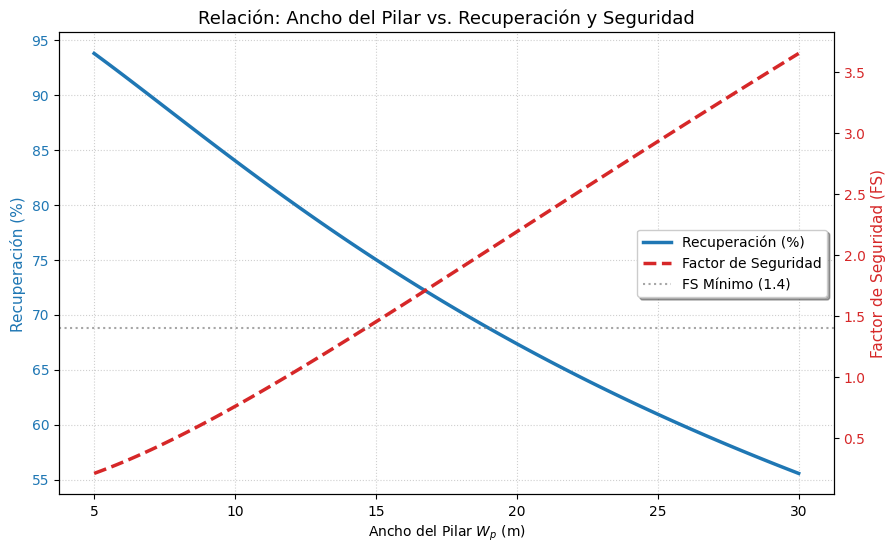

In [5]:
# --- FUNCIONES MATEMÁTICAS ---
def calcular_esfuerzo(sigma_z, wp, w0): 
    return sigma_z * ((wp + w0)**2 / wp**2)

def calcular_resistencia(k, wp, h): 
    return k * (wp**0.5 / h**0.75)

def calcular_recuperacion(wp, w0): 
    return (1 - (wp**2 / (wp + w0)**2)) * 100

def luz_interseccion(w0): 
    return w0 * np.sqrt(2)

# Dimensiones fijas para este ejercicio
w0 = 15.0         # Ancho de cámara (m)
h_pilar = 10.0    # Altura del pilar (m)

# --- VALIDACIÓN DE LA INTERSECCIÓN ---
w_eff = luz_interseccion(w0)
print(f"Luz diagonal en intersecciones: {w_eff:.2f} m")
print(f"Luz Máxima del techo permitida: {luz_maxima:.2f} m")
if w_eff > luz_maxima:
    print("⚠️ ADVERTENCIA: El ancho de cámara elegido provocará colapso en las intersecciones.")
else:
    print("✅ El techo en las intersecciones es estable.")
print("-" * 60)

# Modifica los números dentro de los corchetes con las medidas que quieras probar.
wp_propuestas = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0]

resultados_estudiante = []

for wp in wp_propuestas:
    # Uso de las funciones modulares
    sigma_p = calcular_esfuerzo(sigma_z, wp, w0)
    sp = calcular_resistencia(k, wp, h_pilar)
    
    fs = sp / sigma_p
    recuperacion = calcular_recuperacion(wp, w0)
    
    estado = "✅ SEGURO" if fs >= 1.4 else "❌ RIESGO (Colapso)"
    
    resultados_estudiante.append({
        'Pilar Wp (m)': wp,
        'Esfuerzo (MPa)': round(sigma_p, 2),
        'Resistencia (MPa)': round(sp, 2),
        'Factor Seguridad': round(fs, 2),
        'Recuperación (%)': round(recuperacion, 2),
        'Estado': estado
    })

df_estudiante = pd.DataFrame(resultados_estudiante)
display(HTML("<h3>Resultados de tus propuestas manuales:</h3>"))
display(df_estudiante)

# --- GRÁFICA DE OPTIMIZACIÓN ---
wp_curva = np.linspace(5.0, 30.0, 100)
fs_plot = [calcular_resistencia(k, w, h_pilar) / calcular_esfuerzo(sigma_z, w, w0) for w in wp_curva]
rec_plot = [calcular_recuperacion(w, w0) for w in wp_curva]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Ancho del Pilar $W_p$ (m)')
ax1.set_ylabel('Recuperación (%)', color='tab:blue', fontsize=11)
line1, = ax1.plot(wp_curva, rec_plot, color='tab:blue', linewidth=2.5, label='Recuperación (%)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Factor de Seguridad (FS)', color='tab:red', fontsize=11)
line2, = ax2.plot(wp_curva, fs_plot, color='tab:red', linewidth=2.5, linestyle='--', label='Factor de Seguridad')
ax2.tick_params(axis='y', labelcolor='tab:red')

line3 = ax2.axhline(y=1.4, color='gray', linestyle=':', alpha=0.7, label='FS Mínimo (1.4)')

plt.title('Relación: Ancho del Pilar vs. Recuperación y Seguridad', fontsize=13)
ax1.grid(True, linestyle=':', alpha=0.6)

lns = [line1, line2, line3]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', frameon=True, shadow=True)
plt.show()

### **Paso 4: Simulador Interactivo**

Evaluar dimensiones manualmente es ineficiente en un proyecto real. A continuación, utilizaremos Python para realizar un **Grid Search** (búsqueda en cuadrícula). 

El algoritmo probará miles de combinaciones de $W_0$ (Cámaras) y $W_p$ (Pilares) y filtrará automáticamente aquellos diseños que:
1. Superen la luz máxima en las intersecciones del techo (Riesgo de colapso).
2. Tengan un factor de esbeltez menor a 0.8 (Riesgo de pandeo).
3. No alcancen el Factor de Seguridad (FS) crítico que tú definas.

**Instrucciones:** Ejecuta la celda e interactúa con los controles deslizantes. Observa cómo cambian las gráficas y la tabla del "Top 10" de diseños óptimos (ordenados por mayor recuperación) al modificar la profundidad o el GSI del macizo rocoso.

In [ ]:
def simulador(profundidad_sim, GSI_sim, ucs_sim, H_minado, FS_min_req):
    # --- 1. Cálculos Geomecánicos (Heredando gamma, sigma_t y t_techo globales del Paso 1) ---
    sz = gamma * profundidad_sim
    s_hb = np.exp((GSI_sim - 100) / 9)
    a_hb = 0.5 + (1/6) * (np.exp(-GSI_sim / 15) - np.exp(-20 / 3))
    K_res = ucs_sim * (s_hb ** a_hb)
    
    L_max = np.sqrt((2 * sigma_t * t_techo) / gamma)
    
    # --- 2. Simulación de escenarios ---
    w0_range = np.arange(5.0, min(L_max, 20.0), 0.5)
    wp_range = np.arange(4.0, 25.0, 0.5)
    
    data = []
    for w0 in w0_range:
        # Validación: La diagonal de la intersección NO debe superar L_max
        if luz_interseccion(w0) > L_max:
            continue
            
        for wp in wp_range:
            esbeltez = wp / H_minado
            if esbeltez < 0.8: continue 
            
            # Usando las funciones modulares definidas en el Paso 3
            sig_p = calcular_esfuerzo(sz, wp, w0)
            res_p = calcular_resistencia(K_res, wp, H_minado)
            fs = res_p / sig_p
            
            if fs >= FS_min_req:
                rec = calcular_recuperacion(wp, w0)
                data.append({'W0': w0, 'Wp': wp, 'FS': fs, 'Rec%': rec, 'Wp/H': esbeltez})
                
    df_res = pd.DataFrame(data)

    # --- 3. Creación de Contenedores para salida Horizontal ---
    out_graf = widgets.Output()
    out_tab = widgets.Output()

    if not df_res.empty:
        best_designs = df_res.sort_values(by='Rec%', ascending=False).head(10).reset_index(drop=True)
        
        with out_graf:
            plt.figure(figsize=(7, 5))
            sc = plt.scatter(df_res['FS'], df_res['Rec%'], c=df_res['Wp/H'], cmap='viridis', alpha=1.0, s=20)
            plt.axvline(FS_min_req, color='red', linestyle='--', label='FS Crítico')
            plt.title("Seguridad vs Recuperación", fontsize=12)
            plt.xlabel("Factor de Seguridad (FS)")
            plt.ylabel("Recuperación (%)")
            plt.colorbar(sc, label='Esbeltez (Wp/H)')
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.show()
        
        with out_tab:
            display(HTML("<div style='margin-left: 20px;'><b>Top 10 Diseños Óptimos</b></div>"))
            display(HTML(f"<div style='margin-left: 20px; max-height: 350px; overflow-y: auto;'>{best_designs.to_html(classes='table table-striped table-hover')}</div>"))
    else:
        with out_graf:
            print("❌ No hay diseños viables: El FS no se alcanza o el techo colapsaría en intersecciones.")

    display(widgets.HBox([out_graf, out_tab]))

# Configuración del widget interactivo
widgets.interact(simulador, 
                 profundidad_sim=(100, 1000, 50), 
                 GSI_sim=(30, 95, 5), 
                 ucs_sim=(50, 250, 10),
                 H_minado=(3.0, 15.0, 0.5),
                 FS_min_req=(1.0, 2.5, 0.1))

interactive(children=(IntSlider(value=550, description='profundidad_sim', max=1000, min=100, step=50), IntSlid…

<function __main__.simulador(profundidad_sim, GSI_sim, ucs_sim, H_minado, FS_min_req)>

### **Casos de Estudio: Simulación Room & Pillar**

A continuación, pondremos a prueba los límites de la Teoría del Área Tributaria y el criterio de Hoek-Brown utilizando el simulador. Introduce los parámetros de los siguientes escenarios geológicos y reporta el mejor diseño del "Top 10" (basado en la máxima recuperación posible). 

#### **Caso A: Manto Sedimentario Tabular (Depósito MVT)**
Este escenario representa una operación en rocas sedimentarias de buena competencia, típico de la minería comercial de caliza o depósitos de plomo-zinc tipo Mississippi Valley Type (MVT). El cuerpo mineralizado es somero y la roca huésped presenta buenas condiciones estructurales.

* **Profundidad ($Z$):** 120 m
* **GSI:** 70 (Macizo rocoso en bloques, fracturas cerradas y rugosas)
* **UCS de la roca intacta:** 85 MPa
* **Altura de minado ($H$):** 4.5 m
* **FS Mínimo Requerido:** 1.5

---

#### **Caso B: Cuerpo Mineralizado tipo Skarn Profundo**
Este caso modela el contacto entre una intrusión ígnea y una secuencia calcárea (Skarn). Debido al metamorfismo de contacto, la roca intacta es extremadamente dura, pero el macizo en su conjunto se encuentra a gran profundidad y fuertemente alterado o cizallado por la misma intrusión.

* **Profundidad ($Z$):** 700 m
* **GSI:** 45 (Macizo muy fracturado, superficies falladas o con panizo)
* **UCS de la roca intacta:** 160 MPa
* **Altura de minado ($H$):** 5.0 m
* **FS Mínimo Requerido:** 1.4